## Generate Anchors using K-mean clustering

In [1]:
import sys
print(sys.version)

3.6.1 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [2]:
import numpy as np


def k_mean_cluster(n_anchors, gt_boxes, loss_convergence=1e-5):
    """
    Cluster anchors.
    """
    # initial random centroids
    centroid_indices = np.random.choice(len(gt_boxes), k)
    centroids = []
    for centroid_index in centroid_indices:
        centroids.append(gt_boxes[centroid_index])
        
    # iterate k-means
    anchors, avg_iou, loss = run_k_mean(k, gt_boxes, centroids)
    while True:
        anchors, avg_iou, curr_loss = run_k_mean(k, gt_boxes, anchors)
        if abs(loss - curr_loss) < loss_conv:
            break
        loss = curr_loss
    
    return anchors, avg_iou


def run_k_mean(n_anchors, boxes, centroids):
    """
    Perform K-mean clustering on training ground truth to generate anchors. 
    In the paper, authors argues that generating anchors through anchors would improve Recall of the network

    NOTE: Euclidean distance produces larger errors for larger boxes. Therefore, YOLOv2 did not use Euclidean distance 
          to measure calculate loss. Instead, it uses the following formula:

                    d(box, centroid) = 1−IOU(box, centroid)

    :param num_anchors: K-value , number of desired anchors box
    :param boxes:      list of bounding box in format [x1, y1, w, h]
    :param centroids: 
    :return: 
        new_centroids: set of new anchors
        groups:        wth?
        loss:          compared to current bboxes
    """
    loss = 0
    groups = []
    new_centroids = []
    for i in range(n_anchors):
        groups.append([])
        new_centroids.append(Box(0, 0, 0, 0))

    for box in boxes:
        min_distance = 1
        group_index = 0

        for i, centroid in enumerate(centroids):
            distance = (1 - box_iou(box, centroid))
            if distance < min_distance:
                min_distance = distance
                group_index = i

        groups[group_index].append(box)
        loss += min_distance
        new_centroids[group_index].w += box.w
        new_centroids[group_index].h += box.h

    for i in range(n_anchors):
        if(len(groups[i]) == 0):
            continue
        new_centroids[i].w /= len(groups[i])
        new_centroids[i].h /= len(groups[i])
        
    iou = 0
    counter = 0
    for i, anchor in enumerate(new_centroids):
        for gt_box in groups[i]:
            iou += box_iou(gt_box, anchor)
            counter +=1
            
    avg_iou = iou/counter       
    # print("Average IOU: {:4f}".format(avg_iou))  
    return new_centroids, avg_iou, loss


def convert_bbox(x1, y1, x2, y2): 
    w = float(x2) - float(x1)
    h = float(y2) - float(y1)
    xc= float(x1) + w/2.
    yc= float(y1) + h/2.  
    return xc, yc, w ,h

def scale_rel_box(img_size, box ):
    """
    Scale bounding box relative to image size
    """
    width, height, _  = img_size
    dw = 1./width
    dh = 1./height
    xc = (box.x)*dw
    yc = (box.y)*dh
    w  = (box.w)*dw
    h  = (box.h)*dh
    return xc, yc, w, h

class Box(object):
    def __init__(self, xc, yc, w, h):
        self.x = xc
        self.y = yc
        self.w = w
        self.h = h

def box_iou(b1, b2):
    intersect = box_intersection(b1, b2)
    union = box_union(b1, b2)
    iou = float(intersect / union)
    return iou


def box_intersection(b1, b2):
    w = overlap(b1.x, b1.w, b2.x, b2.w)
    h = overlap(b1.x, b1.h, b2.x, b2.h)
    if (w < 0) or (h < 0): return 0
    area = w * h
    return area


def overlap(x1, w1, x2, w2):
    l1 = x1 - (w1 / 2.)
    l2 = x2 - (w2 / 2.)
    r1 = x1 + (w1 / 2.)
    r2 = x2 + (w2 / 2.)
    left = l1 if l1 >= l2 else l2
    right = r1 if r1 <= r2 else r2
    return right - left


def box_union(b1, b2):
    intersect = box_intersection(b1, b2)
    union = (b1.w * b1.h) + (b2.w * b2.h) - intersect
    return union

In [10]:
k            = 5  # num_anchors
label_path   = 'training.txt'  # lisa extension training data using save_lisa_to_txt(path_to_lisa_training)
loss_conv    = 1e-5
img_size     = [1280, 960, 0]
feature_map  = [d/32 for d in img_size]    # DarkNet19 on YOLOv2 Max-pool 5 times --> output'size shrinked 2^5 = 32 times
gt_boxes = []

with open(label_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        img_path, x1, y1, x2, y2, label = line.rstrip().split(",")
        xc, yc, w, h = convert_bbox(x1, y1, x2, y2)
        xc, yc, w, h = scale_rel_box(img_size, Box(xc, yc, w, h))
        gt_boxes.append(Box(0, 0, float(w), float(h))) # since we calculate w h of anchors, we do not take xc yc into account
print("Number of ground truth boxes: {} boxes".format(len(gt_boxes)))

Number of ground truth boxes: 3672 boxes


In [11]:
## K-MEAN CLUSTERING
anchor_list = []
avg_iou_list = []
for k in list(range(1, 15)):
    anchors, avg_iou = k_mean_cluster(k, gt_boxes, loss_convergence=1e-6)
    print("K = : {:2} | AVG_IOU:{:-4f} ".format(k, avg_iou))
    anchor_list.append(anchors)
    avg_iou_list.append(avg_iou)

K = :  1 | AVG_IOU:0.575513 
K = :  2 | AVG_IOU:0.707510 
K = :  3 | AVG_IOU:0.765600 
K = :  4 | AVG_IOU:0.805572 
K = :  5 | AVG_IOU:0.830067 
K = :  6 | AVG_IOU:0.851326 
K = :  7 | AVG_IOU:0.860660 
K = :  8 | AVG_IOU:0.871665 
K = :  9 | AVG_IOU:0.878004 
K = : 10 | AVG_IOU:0.883690 
K = : 11 | AVG_IOU:0.887038 
K = : 12 | AVG_IOU:0.889878 
K = : 13 | AVG_IOU:0.895427 
K = : 14 | AVG_IOU:0.899340 


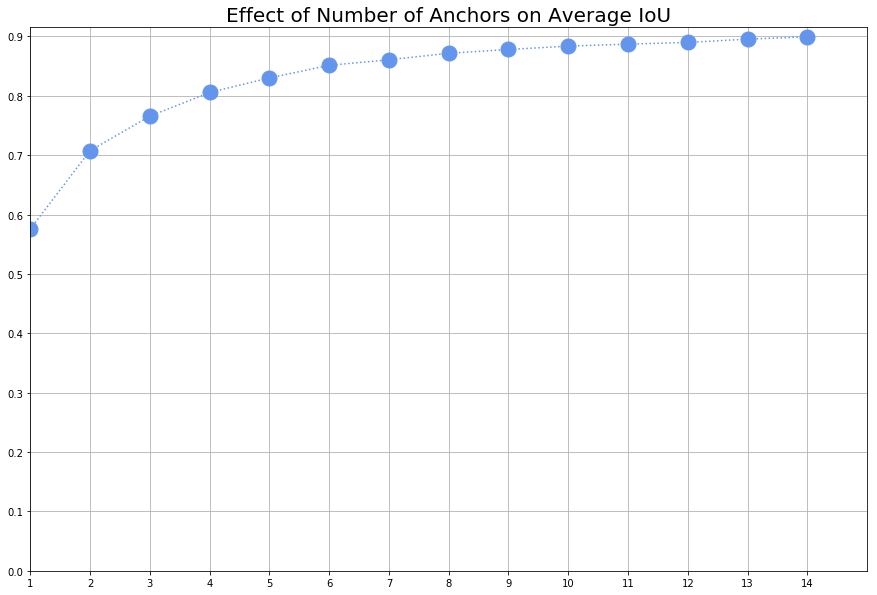

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
marker_style = dict(color='cornflowerblue', linestyle=':', marker='o',
                    markersize=15, markerfacecoloralt='gray')

x = list(range(1, 15))
plt.figure(figsize=(15, 10))
plt.plot(x, avg_iou_list, fillstyle='full', **marker_style)
plt.grid()
plt.yticks(np.arange(0, 1, 0.1))
plt.xticks(np.arange(1, 15, 1.0))
plt.xlim([1, 15] ) # this line
plt.title("Effect of Number of Anchors on Average IoU", fontsize=20)

In [15]:
# print result
print("Anchors box result [relative to feature map] on LISA Dataset:\n")
for anchor in anchor_list[4]:  # Select K = 5 
    print(anchor.w , anchor.h)

Anchors box result [relative to feature map] on LISA Dataset:

0.059577141608391594 0.08738709207459215
0.03283318210930825 0.0483890193566751
0.023717899133663362 0.035715759075907606
0.08816276658767774 0.1294924960505529
0.04450034340659346 0.064308608058608
